In [1]:
all = ls()
rm(all)

options(warn=-1)

In [2]:
library(gtable)
library(dplyr)
library(ggplot2)
library(ggthemes)
library(olsrr) #cooks distance
library(caret) # k fold cross validation
library(lattice) # correlation
library(corrplot)
library(MASS)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: 'olsrr'

The following object is masked from 'package:datasets':

    rivers

Loading required package: lattice
corrplot 0.90 loaded

Attaching package: 'MASS'

The following object is masked from 'package:olsrr':

    cement

The following object is masked from 'package:dplyr':

    select



In [3]:
bushfires = read.csv("forestfires.csv")

In [4]:
head(bushfires)

X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0
7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0
7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0
8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0
8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0
8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0


#### Feature Information

   1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
   2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
   3. month - month of the year: "jan" to "dec" 
   4. day - day of the week: "mon" to "sun"
   5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
   6. DMC - DMC index from the FWI system: 1.1 to 291.3 
   7. DC - DC index from the FWI system: 7.9 to 860.6 
   8. ISI - ISI index from the FWI system: 0.0 to 56.10
   9. temp - temperature in Celsius degrees: 2.2 to 33.30
   10. RH - relative humidity in %: 15.0 to 100
   11. wind - wind speed in km/h: 0.40 to 9.40 
   12. rain - outside rain in mm/m2 : 0.0 to 6.4 
   13. area - the burned area of the forest (in ha): 0.00 to 1090.84

In [5]:
dim(bushfires)

[1] 517  13

In [6]:
glimpse(bushfires)

Observations: 517
Variables: 13
$ X     <int> 7, 7, 7, 8, 8, 8, 8, 8, 8, 7, 7, 7, 6, 6, 6, 6, 5, 8, 6, 6, 6...
$ Y     <int> 5, 4, 4, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4...
$ month <fct> mar, oct, oct, mar, mar, aug, aug, aug, sep, sep, sep, sep, a...
$ day   <fct> fri, tue, sat, fri, sun, sun, mon, mon, tue, sat, sat, sat, f...
$ FFMC  <dbl> 86.2, 90.6, 90.6, 91.7, 89.3, 92.3, 92.3, 91.5, 91.0, 92.5, 9...
$ DMC   <dbl> 26.2, 35.4, 43.7, 33.3, 51.3, 85.3, 88.9, 145.4, 129.5, 88.0,...
$ DC    <dbl> 94.3, 669.1, 686.9, 77.5, 102.2, 488.0, 495.6, 608.2, 692.6, ...
$ ISI   <dbl> 5.1, 6.7, 6.7, 9.0, 9.6, 14.7, 8.5, 10.7, 7.0, 7.1, 7.1, 22.6...
$ temp  <dbl> 8.2, 18.0, 14.6, 8.3, 11.4, 22.2, 24.1, 8.0, 13.1, 22.8, 17.8...
$ RH    <int> 51, 33, 33, 97, 99, 29, 27, 86, 63, 40, 51, 38, 72, 42, 21, 4...
$ wind  <dbl> 6.7, 0.9, 1.3, 4.0, 1.8, 5.4, 3.1, 2.2, 5.4, 4.0, 7.2, 4.0, 6...
$ rain  <dbl> 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...
$ area  <dbl> 0, 0, 

### 2 categorical columns (month and day), others are numerical

In [7]:
unique(bushfires$month)
unique(bushfires$day)

[1] mar oct aug sep apr jun jul feb jan dec may nov
Levels: apr aug dec feb jan jul jun mar may nov oct sep

[1] fri tue sat sun mon wed thu
Levels: fri mon sat sun thu tue wed

In [8]:
bushfires %>%
    group_by(month) %>%
    summarise(counts = length(month)) %>%
    arrange(desc(counts))

month,counts
aug,184
sep,172
mar,54
jul,32
feb,20
jun,17
oct,15
apr,9
dec,9
jan,2


### since data points for months other than Aug, Sep and Mar are very less, we shall group them as others

In [9]:
bushfires$month = as.character(bushfires$month)
bushfires$month[bushfires$month != 'aug' & bushfires$month != 'mar' & bushfires$month != 'sep'] = "others"
bushfires$month = as.factor(bushfires$month)

bushfires %>%
    group_by(month) %>%
    summarise(counts = length(month)) %>%
    arrange(desc(counts))

month,counts
aug,184
sep,172
others,107
mar,54


In [10]:
bushfires %>%
    group_by(day) %>%
    summarise(counts = length(day)) %>%
    arrange(desc(counts))

day,counts
sun,95
fri,85
sat,84
mon,74
tue,64
thu,61
wed,54


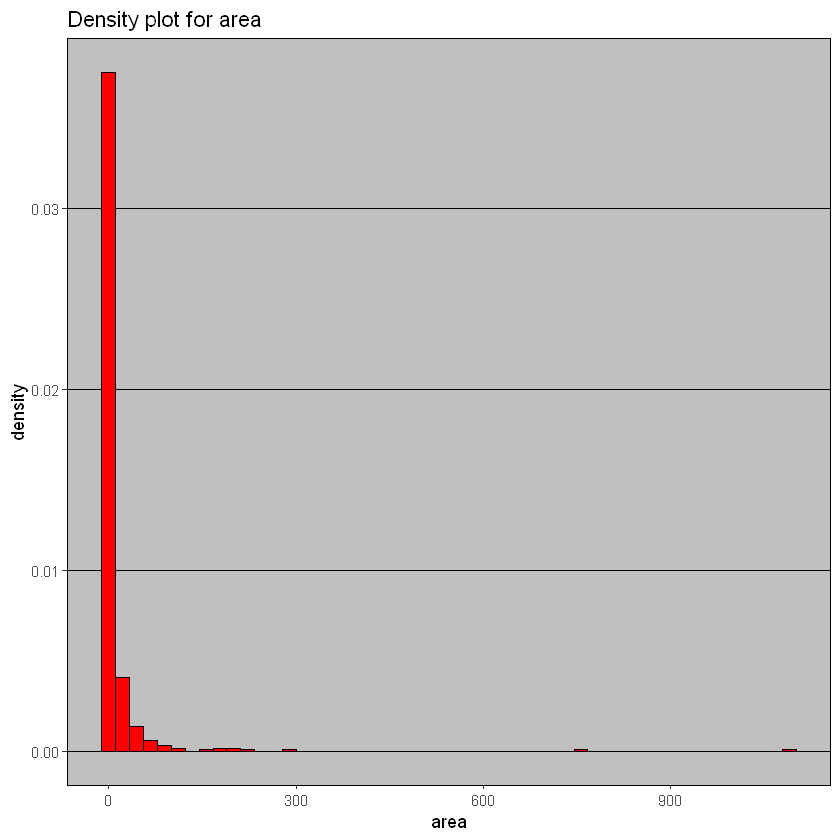

In [11]:
ggplot(bushfires, aes(x = area)) +
    ggtitle("Density plot for area") +
    geom_histogram(aes(y= ..density..), bins = 50, color = "black", fill = "red") +
    theme_excel()

### Area column is extremely right skewed, we shall perform transformations to try and modify it into a normal distribution

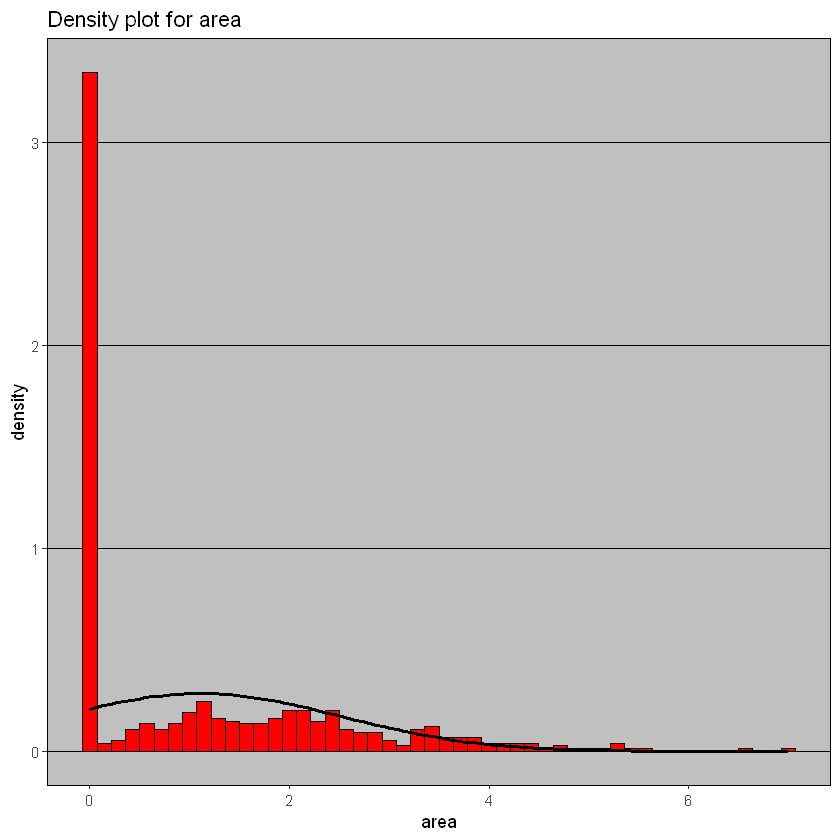

In [12]:
bushfires$org_area = bushfires$area

# applying log transformation
bushfires$area = log(bushfires$area + 1)

ggplot(bushfires, aes(x = area)) +
    geom_histogram(aes(y= ..density..), bins = 50, color = "black", fill = "red") +
    ggtitle("Density plot for area") +
    stat_function(fun = dnorm, args = list(mean = mean(bushfires$area,na.rm=TRUE), sd = sd(bushfires$area,na.rm=TRUE)), col = 'black', size = 0.85) +
    theme_excel()

### since there a lot of unburnt areas, we will omit using these data points to build our model.

In [13]:
burnt = bushfires %>%
    filter(area > 0)

In [14]:
set.seed(123)

train_idx = sample(seq_len(dim(burnt)[1]), size = 0.75 * nrow(burnt))

train = burnt[train_idx, ]
test = burnt[-train_idx, ]

dim(train)
dim(test)

[1] 202  14

[1] 68 14

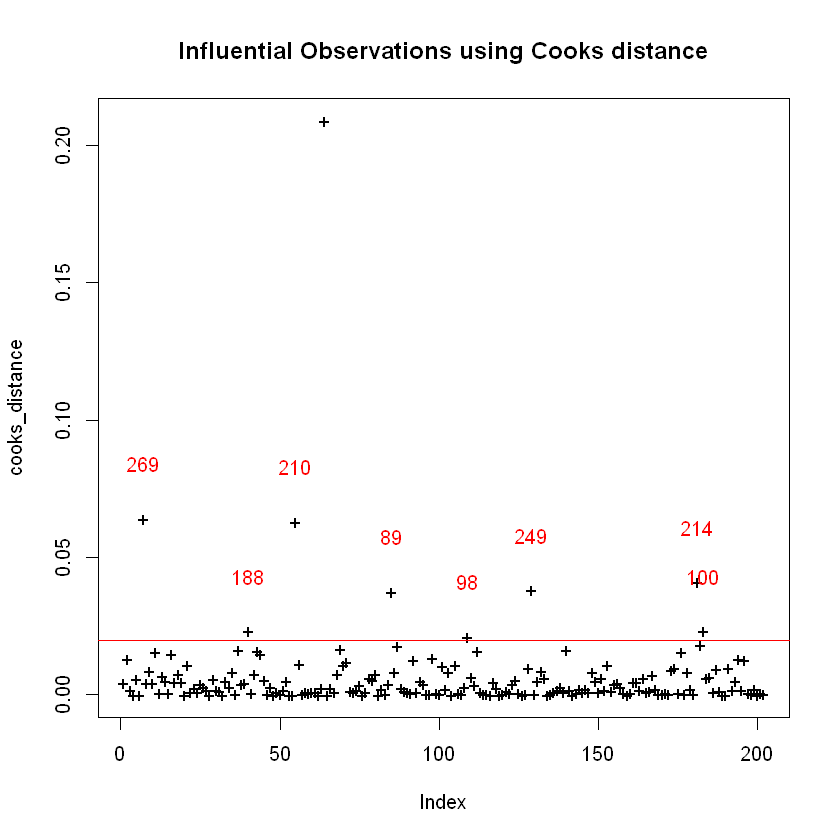

In [15]:
linear_model = lm(area ~ ., data = train[1:13])
cooks_distance <- cooks.distance(linear_model)
plot(cooks_distance, pch="+", main="Influential Observations using Cooks distance")
abline(h = 4/nrow(train), col="red")
text(x=1:length(cooks_distance), y=cooks_distance+0.02,labels=ifelse(cooks_distance>4/nrow(train),names(cooks_distance),""), col="red")

In [16]:
# removing extreme influential points
inf_points = which(cooks_distance > 4/nrow(train))
train = train[-inf_points, ]


Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine



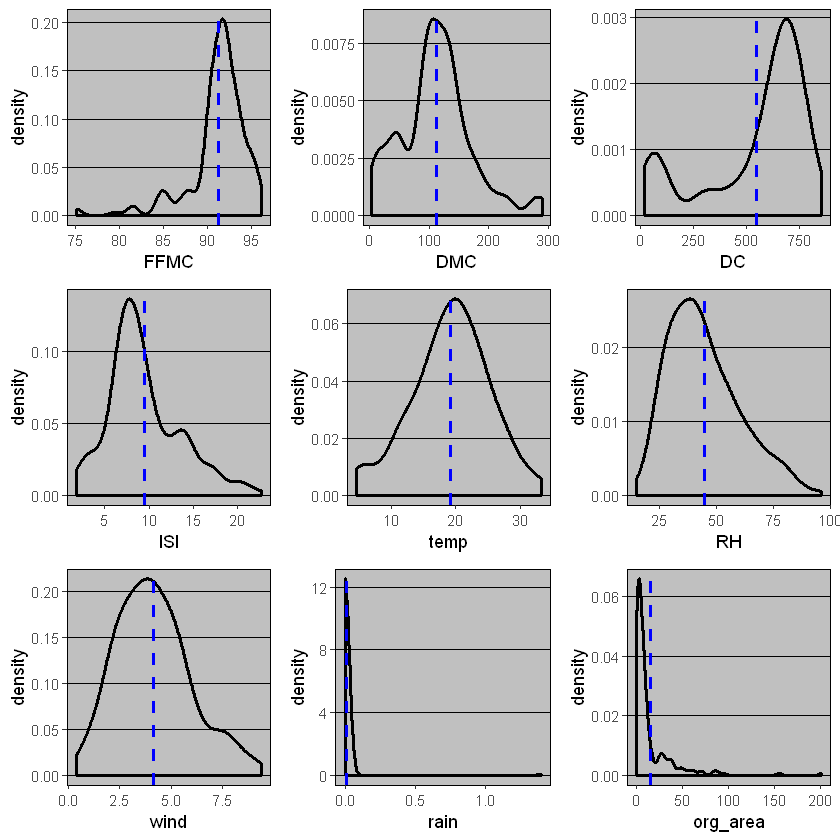

In [17]:
library(gridExtra)

plot1 = ggplot(train, aes(x = FFMC)) +
    geom_density(size = 1) +
    geom_vline(aes(xintercept = mean(FFMC)), color = "blue", linetype = "dashed", size = 1) +
    theme_excel()

plot2 = ggplot(train, aes(x = DMC)) +
    geom_density(size = 1) +
    geom_vline(aes(xintercept = mean(DMC)), color = "blue", linetype = "dashed", size = 1) +
    theme_excel()

plot3 = ggplot(train, aes(x = DC)) +
    geom_density(size = 1) +
    geom_vline(aes(xintercept = mean(DC)), color = "blue", linetype = "dashed", size = 1) +
    theme_excel()

plot4 = ggplot(train, aes(x = ISI)) +
    geom_density(size = 1) +
    geom_vline(aes(xintercept = mean(ISI)), color = "blue", linetype = "dashed", size = 1) +
    theme_excel()

plot5 = ggplot(train, aes(x = temp)) +
    geom_density(size = 1) +
    geom_vline(aes(xintercept = mean(temp)), color = "blue", linetype = "dashed", size = 1) +
    theme_excel()

plot6 = ggplot(train, aes(x = RH)) +
    geom_density(size = 1) +
    geom_vline(aes(xintercept = mean(RH)), color = "blue", linetype = "dashed", size = 1) +
    theme_excel()

plot7 = ggplot(train, aes(x = wind)) +
    geom_density(size = 1) +
    geom_vline(aes(xintercept = mean(wind)), color = "blue", linetype = "dashed", size = 1) +
    theme_excel()

plot8 = ggplot(train, aes(x = rain)) +
    geom_density(size = 1) +
    geom_vline(aes(xintercept = mean(rain)), color = "blue", linetype = "dashed", size = 1) +
    theme_excel()

plot9 = ggplot(train, aes(x = org_area)) +
    geom_density(size = 1) +
    geom_vline(aes(xintercept = mean(org_area)), color = "blue", linetype = "dashed", size = 1) +
    theme_excel()

grid.arrange(plot1, plot2, plot3, plot4, plot5, plot6, plot7, plot8, plot9,  nrow = 3)

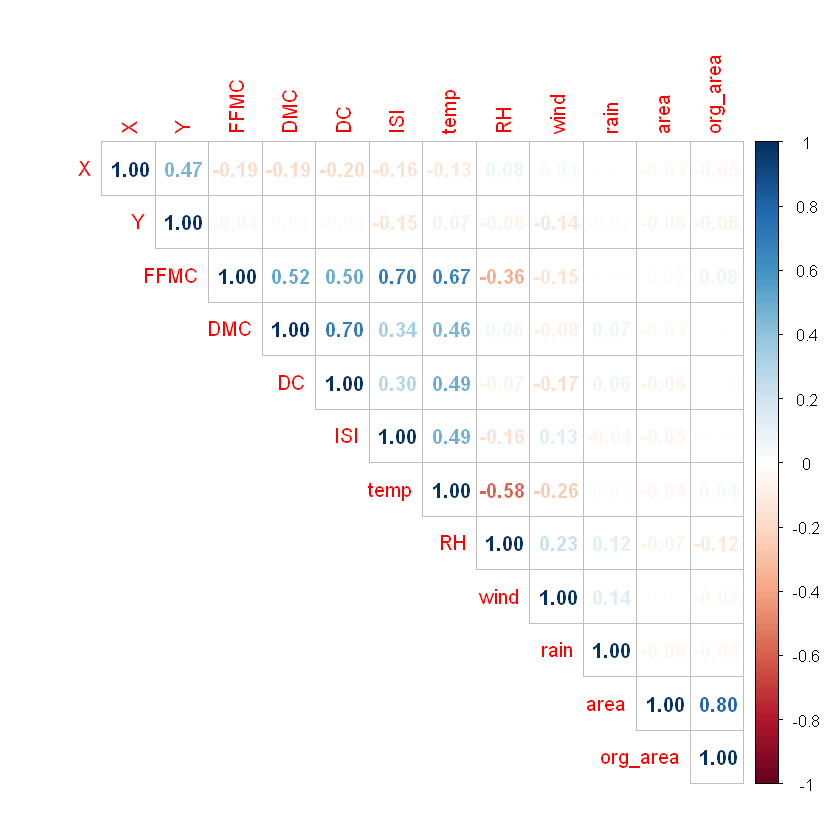

In [18]:
# finding numerical columns
numCols <- unlist(lapply(train, is.numeric))

# displaying correlation matrix
cor_m = cor(train[, numCols])
corrplot(cor_m, method = 'number', type = 'upper')

In [19]:
head(train, 3)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,org_area
179,7,4,sep,fri,88.2,55.2,732.3,11.6,15.2,64,3.1,0,0.4187103,0.52
14,9,9,others,sun,90.1,68.6,355.2,7.2,24.8,29,2.2,0,0.8586616,1.36
195,3,4,sep,sun,90.5,96.7,750.5,11.4,20.6,55,5.4,0,3.2422017,24.59


In [20]:
lin_model <- lm(area ~ . - org_area, data = train)

In [21]:
sfaic = ols_step_forward_aic(lin_model, penter = 0.8)
sfaic


                        Selection Summary                         
-----------------------------------------------------------------
Variable       AIC      Sum Sq      RSS       R-Sq      Adj. R-Sq 
-----------------------------------------------------------------
month        597.214    12.418    236.837    0.04982      0.03474 
FFMC         597.154    14.933    234.323    0.05991      0.03991 
DC           595.446    19.392    229.864    0.07780      0.05314 
DMC          595.170    22.087    227.169    0.08861      0.05921 
-----------------------------------------------------------------

In [22]:
sbaic = ols_step_backward_aic(lin_model, penter = 0.8)
sbaic



                    Backward Elimination Summary                    
------------------------------------------------------------------
Variable        AIC        RSS      Sum Sq     R-Sq      Adj. R-Sq 
------------------------------------------------------------------
Full Model    608.974    213.257    35.998    0.14442      0.05046 
rain          606.974    213.257    35.998    0.14442      0.05591 
X             604.984    213.269    35.986    0.14437      0.06126 
ISI           603.046    213.337    35.918    0.14410      0.06629 
Y             601.142    213.444    35.811    0.14367      0.07110 
wind          599.411    213.742    35.514    0.14248      0.07503 
temp          598.180    214.594    34.661    0.13906      0.07653 
day           596.770    226.698    22.557    0.09050      0.05608 
RH            595.170    227.169    22.087    0.08861      0.05921 
------------------------------------------------------------------


### From the correlation table above, it can be seen that

DMC, DC

FFMC, ISI

FFMC, temp

temp, DMC

X, Y 


have strong correlation

### We shall therefore remove columns X, temp, DMC, ISI

In [23]:
head(train, 3)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,org_area
179,7,4,sep,fri,88.2,55.2,732.3,11.6,15.2,64,3.1,0,0.4187103,0.52
14,9,9,others,sun,90.1,68.6,355.2,7.2,24.8,29,2.2,0,0.8586616,1.36
195,3,4,sep,sun,90.5,96.7,750.5,11.4,20.6,55,5.4,0,3.2422017,24.59


In [24]:
train = subset(train, select = -c(X, DMC, ISI, temp))

In [25]:
head(train, 3)

,Y,month,day,FFMC,DC,RH,wind,rain,area,org_area
179,4,sep,fri,88.2,732.3,64,3.1,0,0.4187103,0.52
14,9,others,sun,90.1,355.2,29,2.2,0,0.8586616,1.36
195,4,sep,sun,90.5,750.5,55,5.4,0,3.2422017,24.59


### model building

In [26]:
model = lm(area ~ ., data = train[1:9])

summary(model)


Call:
lm(formula = area ~ ., data = train[1:9])

Residuals:
    Min      1Q  Median      3Q     Max 
-2.1955 -0.7424 -0.1251  0.7135  3.0152 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.7225034  3.2021314  -0.850 0.396354    
Y           -0.0178711  0.0693461  -0.258 0.796932    
monthmar    -0.0791471  0.5350822  -0.148 0.882578    
monthothers  0.1863630  0.3507333   0.531 0.595841    
monthsep     0.8287422  0.2381211   3.480 0.000631 ***
daymon      -0.0796713  0.3090275  -0.258 0.796851    
daysat       0.6800782  0.2983959   2.279 0.023854 *  
daysun       0.3985771  0.2800807   1.423 0.156473    
daythu       0.0430132  0.3396549   0.127 0.899371    
daytue       0.2155460  0.3051492   0.706 0.480891    
daywed      -0.0137721  0.3137092  -0.044 0.965033    
FFMC         0.0564068  0.0342134   1.649 0.100988    
DC          -0.0013922  0.0008503  -1.637 0.103369    
RH          -0.0034456  0.0059873  -0.575 0.565698    
wind         0.02

# Checking for linear regression assumptions

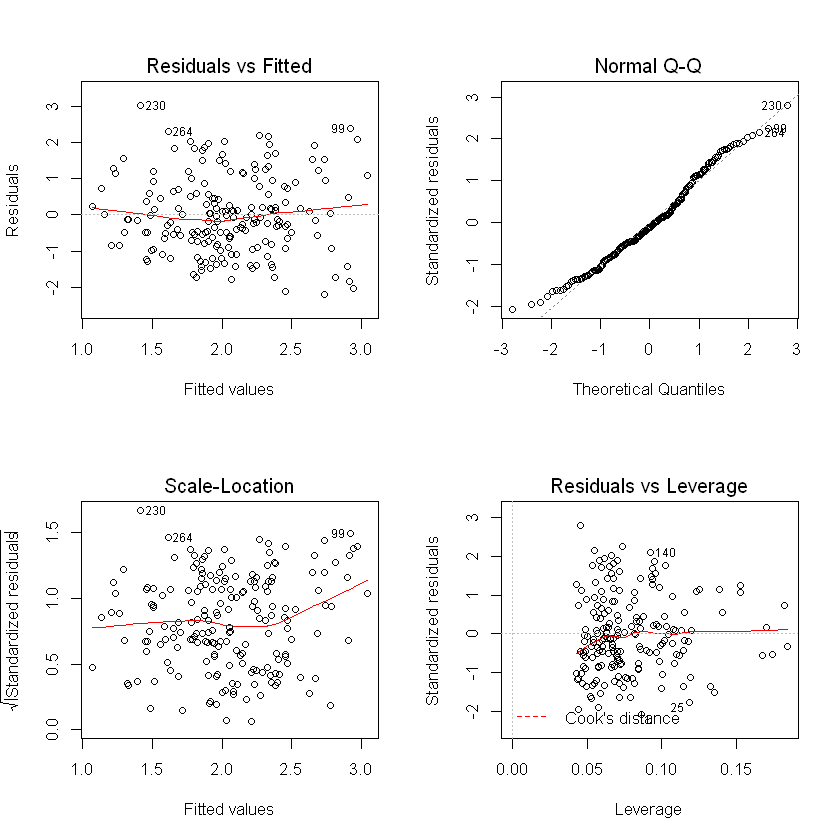

In [27]:
par(mfrow=c(2,2))
plot(model)

### It can be seen that our linear regression assumptions are met. Also, homoscedasticity is met. 

### testing the model on test data

In [28]:
test$pred = predict(model, test)

### plotting the actual values and our predictions

In [29]:
test$error = test$area - test$pred

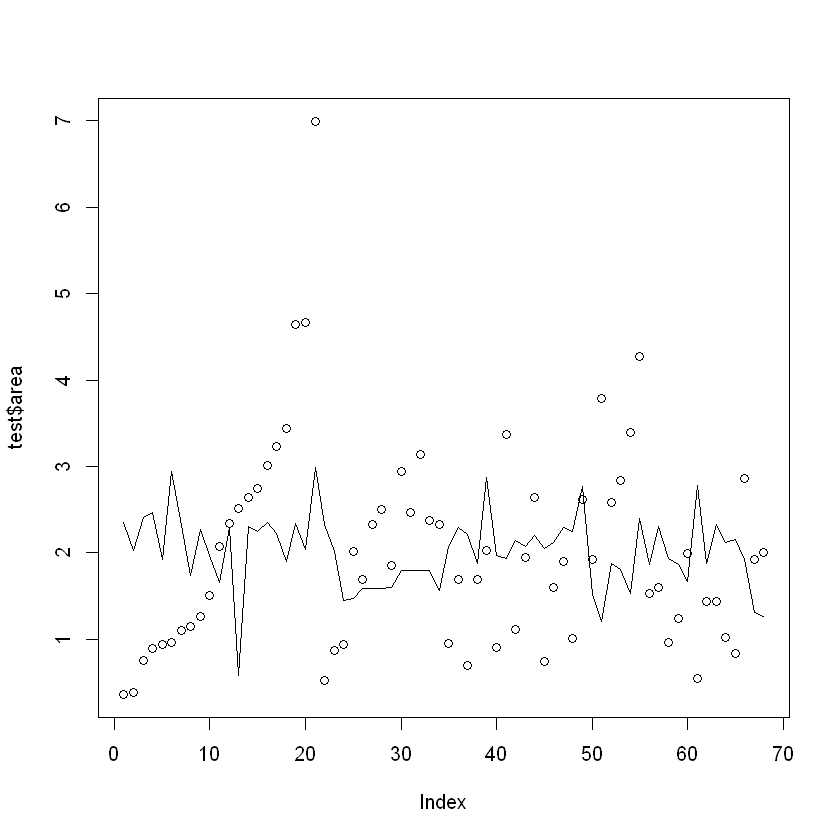

In [30]:
plot(test$area)
lines(test$pred)

### We might need to try another model as linear regression does not seem to work well.